# Fase 3: Data Preparation

# Imports y carga de datos

_Cargamos el DataFrame que ya limpiaste／entendiste en la fase anterior._

In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor



### Cargar datos desde un archivo CSV

In [77]:
path = r'C:\Users\LuisSalamanca\Desktop\Duoc\Machine\ML_Proyecto_Semestral\data\01_raw\Anexo_ET_demo_round_traces_2022.csv'

try:
    df = pd.read_csv(path, sep=';', low_memory=False)
    print(f'Dataset cargado: {df.shape}')
except Exception as e:
    print(f"Error al cargar los datos: {e}")

Dataset cargado: (79157, 30)


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79157 entries, 0 to 79156
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   79157 non-null  int64  
 1   Map                          79157 non-null  object 
 2   Team                         79155 non-null  object 
 3   InternalTeamId               79157 non-null  int64  
 4   MatchId                      79157 non-null  int64  
 5   RoundId                      79157 non-null  int64  
 6   RoundWinner                  79157 non-null  object 
 7   MatchWinner                  79156 non-null  object 
 8   Survived                     79157 non-null  bool   
 9   AbnormalMatch                79157 non-null  bool   
 10  TimeAlive                    79157 non-null  object 
 11  TravelledDistance            79157 non-null  object 
 12  RLethalGrenadesThrown        79157 non-null  int64  
 13  RNonLethalGrenad

### Limpiar el DataFrame eliminando columnas innecesarias y manejando valores nulos

In [79]:
# Hacer una copia para evitar modificar el original
df_clean = df.copy()

In [80]:
# Eliminar columnas innecesarias
columns_to_drop = [
    'Unnamed: 0', 'InternalTeamId', 'FirstKillTime', 'TimeAlive', 'TravelledDistance', 'AbnormalMatch'
]

df_clean = df_clean.drop(columns=[c for c in columns_to_drop if c in df_clean.columns])

In [81]:
# Eliminamos los valores nulos
for col in df_clean:
    if col in df_clean.columns:
        print(f"Valores nulos en {col}: {df_clean[col].isnull().sum()}")

df_clean = df_clean.dropna()

Valores nulos en Map: 0
Valores nulos en Team: 2
Valores nulos en MatchId: 0
Valores nulos en RoundId: 0
Valores nulos en RoundWinner: 0
Valores nulos en MatchWinner: 1
Valores nulos en Survived: 0
Valores nulos en RLethalGrenadesThrown: 0
Valores nulos en RNonLethalGrenadesThrown: 0
Valores nulos en PrimaryAssaultRifle: 0
Valores nulos en PrimarySniperRifle: 0
Valores nulos en PrimaryHeavy: 0
Valores nulos en PrimarySMG: 0
Valores nulos en PrimaryPistol: 0
Valores nulos en RoundKills: 0
Valores nulos en RoundAssists: 0
Valores nulos en RoundHeadshots: 0
Valores nulos en RoundFlankKills: 0
Valores nulos en RoundStartingEquipmentValue: 0
Valores nulos en TeamStartingEquipmentValue: 0
Valores nulos en MatchKills: 0
Valores nulos en MatchFlankKills: 0
Valores nulos en MatchAssists: 0
Valores nulos en MatchHeadshots: 0


In [82]:
# Crear un diccionario para los mapas
map_mapping = {}
for i, map_name in enumerate(df_clean["Map"].unique()):
  map_mapping[map_name] = i

# Asignar los valores del diccionario a la columna "Map"
df_clean["Map"] = df_clean["Map"].map(map_mapping)

df_clean['Team'] = df_clean['Team'].apply(lambda x: 1 if str(x).strip().lower() == 'terrorist' else 2)
df_clean.head()

,Map,Team,MatchId,RoundId,RoundWinner,MatchWinner,Survived,RLethalGrenadesThrown,RNonLethalGrenadesThrown,PrimaryAssaultRifle,...,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
0,0,1,4,1,False,True,False,0,4,0.0,...,0,0,0,0,750,4400,0,0,0,0
1,0,1,4,1,False,True,False,0,0,0.0,...,0,0,0,0,800,4400,0,0,0,0
2,0,1,4,1,False,True,False,0,0,0.0,...,0,0,0,0,1000,4400,0,0,0,0
3,0,1,4,1,False,True,False,0,0,0.0,...,0,0,0,0,850,4400,0,0,0,0
4,0,1,4,1,False,True,True,1,1,0.0,...,0,0,0,0,1000,4400,0,0,0,0


In [83]:
df_clean2 = df_clean.copy()

boolean_cols = [ 'RoundWinner', 'MatchWinner', 'Survived', 'AbnormalMatch']
truth_map = {'True': True, 'False': False,
             'true': True, 'false': False,
             1: True, 0: False}      # por si llegan números como strings

for col in boolean_cols:
    if col in df_clean2.columns:
        df_clean2[col] = df_clean2[col].map(truth_map).astype('bool')

In [84]:
float_cols = ['PrimaryAssaultRifle', 'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG']

for col in float_cols:
    if col in df_clean2.columns:
        df_clean2[col] = (df_clean2[col] >= 0.5).astype(int)
        
df_clean2.head(2)

,Map,Team,MatchId,RoundId,RoundWinner,MatchWinner,Survived,RLethalGrenadesThrown,RNonLethalGrenadesThrown,PrimaryAssaultRifle,...,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
0,0,1,4,1,False,True,False,0,4,0,...,0,0,0,0,750,4400,0,0,0,0
1,0,1,4,1,False,True,False,0,0,0,...,0,0,0,0,800,4400,0,0,0,0


In [85]:
# Eliminar duplicados si existen
df_clean = df_clean2.drop_duplicates()

In [86]:
print(f"Dataset limpio: {df_clean.shape}")

Dataset limpio: (78744, 24)


In [87]:
# Guardado del dataset limpio
path = r'C:\Users\LuisSalamanca\Desktop\Duoc\Machine\ML_Proyecto_Semestral\data\02_intermediate\clear_dataset.csv'

try:
    import os
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df_clean.to_csv(path, index=False)
    print(f"Datos guardados en: {path}")
except Exception as e:
    print(f"Error al guardar los datos: {e}")

Datos guardados en: C:\Users\LuisSalamanca\Desktop\Duoc\Machine\ML_Proyecto_Semestral\data\02_intermediate\clear_dataset.csv


### Analizar la calidad de los datos

In [88]:
# Cargaar datos limpios
path = r'C:\Users\LuisSalamanca\Desktop\Duoc\Machine\ML_Proyecto_Semestral\data\02_intermediate\clear_dataset.csv'

try:
    df_2 = pd.read_csv(path)
    print(f'Datos procesados cargados: {df.shape}')
except Exception as e:
    print(f"Error al cargar los datos procesados: {e}")

Datos procesados cargados: (79157, 30)


In [89]:
# Calcular estadísticas de calidad
stats = pd.DataFrame({
    'dtype': df_clean.dtypes,
    'count': df_clean.count(),
    'unique': df_clean.nunique(),
})

# Agregar estadísticas para columnas numéricas
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    stats.loc[col, 'min'] = df_clean[col].min()
    stats.loc[col, 'max'] = df_clean[col].max()
    stats.loc[col, 'mean'] = df_clean[col].mean().round(2)
    stats.loc[col, 'median'] = df_clean[col].median()
    std_value = df_clean[col].std()
    stats.loc[col, 'std'] = np.round(std_value, 2) if not np.isnan(std_value) else np.nan
    stats.loc[col, 'skew'] = df_clean[col].skew().round(2)

print("\nEstadísticas de calidad de datos:")
print(stats)


Estadísticas de calidad de datos:
                             dtype  count  unique  min      max      mean  \
Map                          int64  78744       4  0.0      3.0      1.36   
Team                         int64  78744       2  1.0      2.0      1.50   
MatchId                      int64  78744     333  4.0    511.0    250.61   
RoundId                      int64  78744      36  1.0     36.0     12.82   
RoundWinner                   bool  78744       2  NaN      NaN       NaN   
MatchWinner                   bool  78744       2  NaN      NaN       NaN   
Survived                      bool  78744       2  NaN      NaN       NaN   
RLethalGrenadesThrown        int64  78744       5  0.0      4.0      0.50   
RNonLethalGrenadesThrown     int64  78744       7  0.0      6.0      1.26   
PrimaryAssaultRifle          int64  78744       2  0.0      1.0      0.68   
PrimarySniperRifle           int64  78744       2  0.0      1.0      0.09   
PrimaryHeavy                 int64  78744

# Feature Engineering

## Módulo para ingeniería de características para los datos de CS:GO

In [90]:
# Cargaar datos limpios
path = r'C:\Users\LuisSalamanca\Desktop\Duoc\Machine\ML_Proyecto_Semestral\data\02_intermediate\clear_dataset.csv'

try:
    df_FE = pd.read_csv(path)
    print(f'Datos procesados cargados: {df.shape}')
except Exception as e:
    print(f"Error al cargar los datos procesados: {e}")

Datos procesados cargados: (79157, 30)


### Crear características básicas para mejorar los modelos

In [109]:
# Copiar DataFrame original
df_new = df_FE.copy()

# Reemplazar NaNs si es necesario
df_new.fillna(0, inplace=True)

# 1. Eficiencia Económica: kills por cada unidad monetaria invertida
df_new['EconomicEfficiency'] = df_new['RoundKills'] / (df_new['RoundStartingEquipmentValue'] + 1)

# 2. Efectividad de granadas letales
if {'RLethalGrenadesThrown'}.issubset(df_new.columns):
    df_new['GrenadeEffectiveness'] = df_new['RoundKills'] / (df_new['RLethalGrenadesThrown'] + 1)

# 3. Score de Efectividad: recompensa ponderada por kills y asistencias
df_new['EffectivenessScore'] = df_new['RoundKills'] * 2 + df_new['RoundAssists']

# 4. Uso de arma primaria (True si usó alguna primaria)
weapon_cols = [col for col in df_new.columns if col.startswith('Primary')]
if weapon_cols:
    df_new['UsingPrimaryWeapon'] = df_new[weapon_cols].gt(0).any(axis=1)

# 5. Total de granadas lanzadas
if {'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown'}.issubset(df_new.columns):
    df_new['TotalGrenades'] = df_new['RLethalGrenadesThrown'] + df_new['RNonLethalGrenadesThrown']

# 6. Ventaja de equipamiento (jugador vs equipo promedio)
if {'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue'}.issubset(df_new.columns):
    df_new['EquipmentAdvantage'] = df_new['RoundStartingEquipmentValue'] - df_new['TeamStartingEquipmentValue'] / 5

# 7. KDA Ratio ajustado (sobrevive = divisor 1; muere = divisor 2)
df_new['KDA'] = (df_new['RoundKills'] + df_new['RoundAssists']) / df_new['Survived'].apply(lambda x: 1 if x else 2)

# 8. Kill-Assist Ratio
df_new['KillAssistRatio'] = df_new['RoundKills'] / (df_new['RoundAssists'] + 1)

# 9. Stealth Kills Ratio (kills por flanqueo)
df_new['StealthKillsRatio'] = df_new.apply(
    lambda row: row['RoundFlankKills'] / row['RoundKills'] if row['RoundKills'] > 0 else 0,
    axis=1
)

print(f"✅ DataFrame con características básicas: {df_new.shape}")

✅ DataFrame con características básicas: (78744, 33)


In [ ]:
# Crear categorías multiclase de EffectivenessScore
df_new['EffectivenessLevel'] = pd.cut(
    df_new['EffectivenessScore'].astype(float),
    bins=[-np.inf, 0, 5, 15, np.inf],
    labels=['Bajo', 'Medio', 'Alto', 'Experto']
)

print(df_new['EffectivenessLevel'].value_counts())


In [ ]:
# Top 10% de KDA como clase positiva
kda_threshold = df_new['KDA'].quantile(0.9)
df_new['TopKDA'] = (df_new['KDA'] >= kda_threshold).astype(int)
print(df_new['TopKDA'].value_counts())


In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Features y target
features = [
    'EconomicEfficiency',
    'EffectivenessScore',
    'EquipmentAdvantage',
    'KillAssistRatio',
    'StealthKillsRatio'
]
target = 'KDA'

# Revisar que todas las columnas existan y no tengan NaN
df_new = df_new[features + [target]].fillna(0)

X = df_new[features]
y = df_new[target]


In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [112]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [114]:
y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

# Mostrar coeficientes
coef_df = pd.DataFrame({
    "Feature": features,
    "Coef": model.coef_
})
print(coef_df)


Mean Squared Error: 0.08364695657237049
R^2 Score: 0.8853405667259366
              Feature      Coef
0  EconomicEfficiency -0.598433
1  EffectivenessScore  0.535442
2  EquipmentAdvantage  0.000002
3     KillAssistRatio -0.207983
4   StealthKillsRatio -0.045501


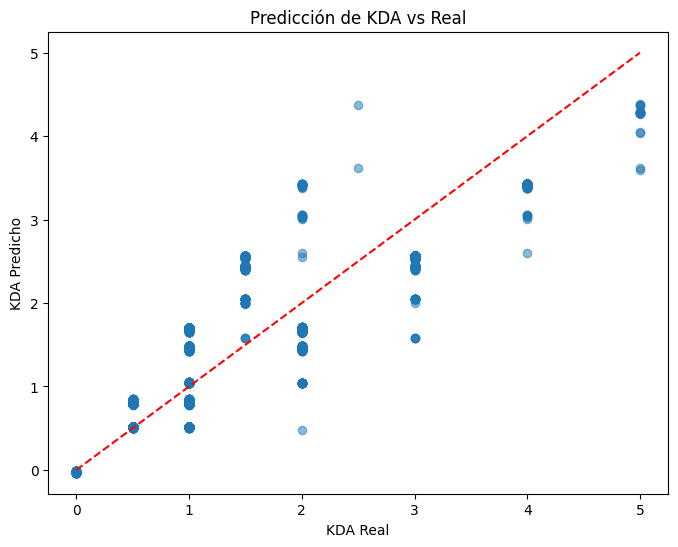

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('KDA Real')
plt.ylabel('KDA Predicho')
plt.title('Predicción de KDA vs Real')
plt.show()


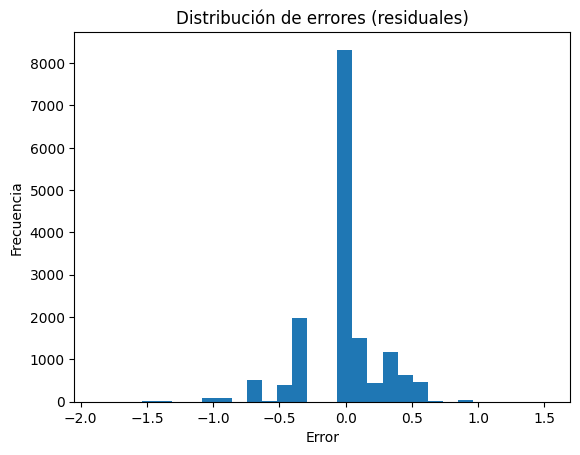

In [97]:
residuals = y_test - y_pred
plt.hist(residuals, bins=30)
plt.title('Distribución de errores (residuales)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
df_new

In [116]:
# Guardado del dataset limpio
path = r'C:\Users\LuisSalamanca\Desktop\Duoc\Machine\ML_Proyecto_Semestral\data\03_features\engineered_data.csv'

try:
    import os
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df_new.to_csv(path, index=False)
    print(f"Datos guardados en: {path}")
except Exception as e:
    print(f"Error al guardar los datos: {e}")

Datos guardados en: C:\Users\LuisSalamanca\Desktop\Duoc\Machine\ML_Proyecto_Semestral\data\03_features\engineered_data.csv
